### Imports

In [1]:
import pandas as pd
import numpy as np

import os, sys

import plotly
import plotly.express as px

# change the default renderer so it shows on something like Github
plotly.io.renderers.default = 'png'

#add my own file with custom utility functions as a module
utils_path = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir)))
if utils_path not in sys.path:
    sys.path.append(utils_path)

import aku_utils as ak

# pandas options
pd.options.display.max_columns = 100
pd.options.display.max_rows =  200
# pd.options.display.max_info_rows = 1690785
pd.options.display.max_info_columns = 200
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.date_dayfirst = True
pd.options.mode.chained_assignment = None

### Data overview

In [2]:
df = pd.read_csv(os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'data', 'telco_processed.csv'))))
df.head()

,gender,age,married,dependents,number_of_dependents,city,zip_code,latitude,longitude,population,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,churn,ibm_spss_churn_prob,cltv,churn_category,churn_reason,new_customer
0,1,78,0,0,0,Los Angeles,90022,34.02,-118.16,68701,0,0,1,NaN,0,0.00,0,1,DSL,8,0,0,1,0,0,1,0,0,Month-to-Month,1,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,3,1,91,5433,Competitor,Competitor offered more data,0
1,0,74,1,1,1,Los Angeles,90063,34.04,-118.19,55668,1,1,8,Offer E,1,48.85,1,1,Fiber Optic,17,0,1,0,0,0,0,0,1,Month-to-Month,1,Credit Card,80.65,633.30,0.00,0,390.80,"1,024.10",3,1,69,5302,Competitor,Competitor made better offer,0
2,1,71,0,1,3,Los Angeles,90065,34.11,-118.23,47534,0,0,18,Offer D,1,11.33,1,1,Fiber Optic,52,0,0,0,0,1,1,1,1,Month-to-Month,1,Bank Withdrawal,95.45,"1,752.55",45.61,0,203.94,"1,910.88",2,1,81,3179,Competitor,Competitor made better offer,0
3,0,78,1,1,1,Inglewood,90303,33.94,-118.33,27778,1,1,25,Offer C,1,19.76,0,1,Fiber Optic,12,0,1,1,0,1,1,0,1,Month-to-Month,1,Bank Withdrawal,98.50,"2,514.50",13.43,0,494.00,"2,995.07",2,1,88,5337,Dissatisfaction,Limited range of services,0
4,0,80,1,1,1,Whittier,90602,33.97,-118.02,26265,1,1,37,Offer C,1,6.33,1,1,Fiber Optic,14,0,0,0,0,0,0,0,1,Month-to-Month,1,Bank Withdrawal,76.50,"2,868.15",0.00,0,234.21,"3,102.36",2,1,67,2793,Price,Extra data charges,0


# Client portrait

First of all, let's explore what kind of people are using our services

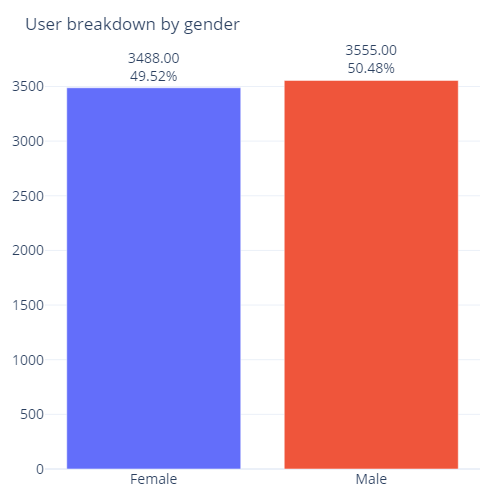

In [3]:
out = df.groupby('gender', as_index=False).size().replace({0 : 'Female', 1 : 'Male'})
ak.plot.bar(out, title='User breakdown by gender')

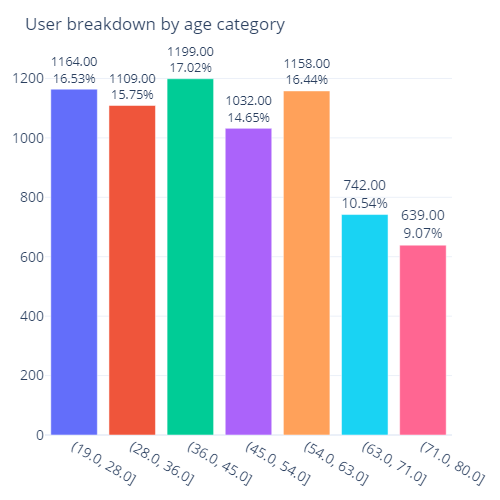

In [4]:
df['age_bin'], age_bins = pd.cut(df['age'], 7, precision=0, retbins=True)
df['age_bin'] = df['age_bin'].astype('str')

out = df.groupby('age_bin', as_index=False).size()
user_age = ak.plot.bar(out, title='User breakdown by age category')
user_age

It would be nice to compare our customer age breakdown with state age breakdown to see if some specific age groups are interested in our services or we undertarget these demographic groups.

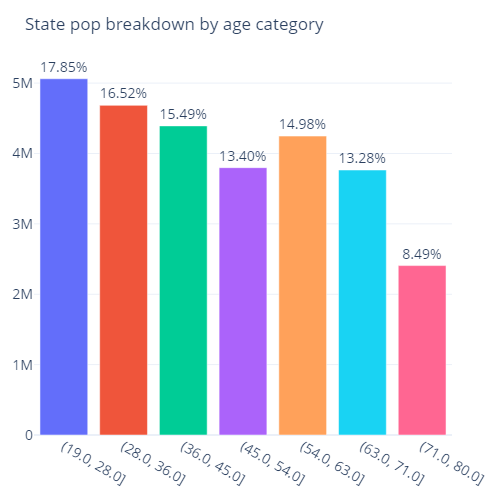

In [5]:
cali_pop = pd.read_excel(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'data', 'P1B_State_Age.xlsx'), sheet_name='State Population by Age', skiprows=2)
cali_pop = cali_pop[['Population', '2022']].rename({'Population' : 'age', '2022' : 'pop'}, axis=1)
cali_pop['age'] = pd.to_numeric(cali_pop['age'], errors='coerce')
cali_pop = cali_pop[(cali_pop['age'] > 18) & (cali_pop['age'] < 81)]
cali_pop['age_bin'] = pd.cut(cali_pop['age'], bins=age_bins, precision=0).astype('str')
cali_pop = cali_pop.drop('age', axis=1)

out = cali_pop.groupby('age_bin', as_index=False)['pop'].sum()
state_age = ak.plot.bar(out, display_values=False, title='State pop breakdown by age category')
state_age

We see no signicant changes between customer and state population age: people of age 28-63 are slightly more prevalent in our customer base, but it's nothing significant.

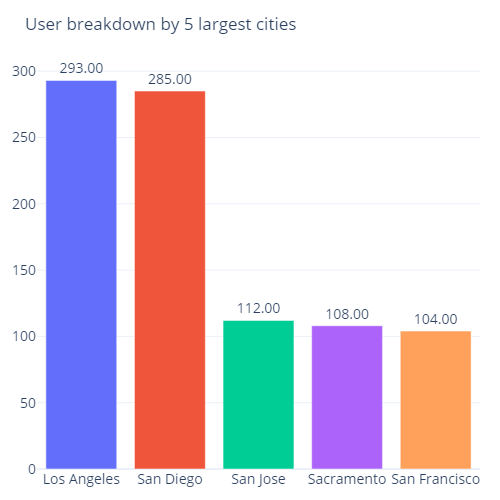

In [6]:
out = df.groupby('city', as_index=False).size().nlargest(5, 'size')
ak.plot.bar(out, title='User breakdown by 5 largest cities', display_pct=False)

This result also coincides with state's largest cities, so no anomalies here.

Let's see if a ZIP code coincides with exactly one latitude-longitude position. To prove it, we calculate variation of latitude and longitude grouped by the ZIP:

In [7]:
df.groupby('zip_code').agg({'latitude' : 'std', 'longitude' : 'std'}).sum()

latitude    0.00
longitude   0.00
dtype: float64

As you can see, the standard deviation (for all ZIPs) is zero, which proves our hypothesis. As ZIP represents one specific area, we can group our customers by latitude and longitude to see what exact areas are our customers from, which allows us to not rely on bar plots, which can only give us partial information.

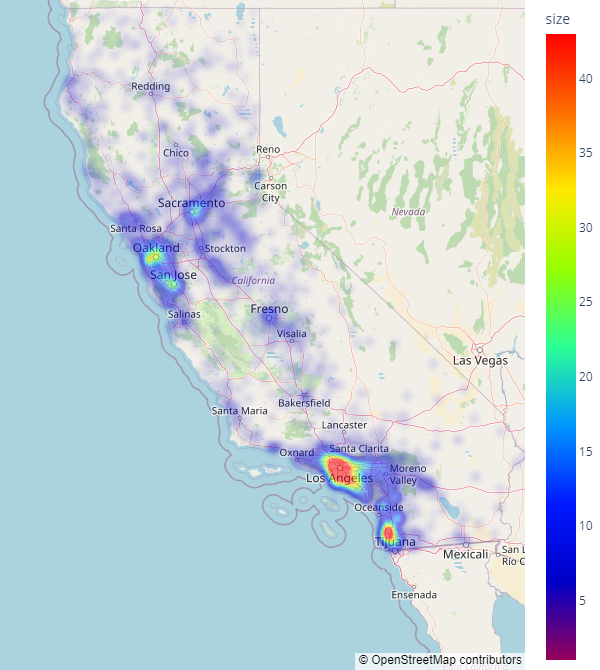

In [8]:
fig = px.density_mapbox(df.groupby(['latitude', 'longitude'], as_index=False).size(),
                        lat = 'latitude', lon = 'longitude', z = 'size',
                        radius = 12, zoom = 5, opacity = 0.5, color_continuous_scale='rainbow', mapbox_style = 'open-street-map'
                        )

fig.update_layout(ak.plot.default_map_layout, width=600, height=670)

fig.show()

We can see that, although our customer base is concentrated in a couple of the biggest cities in the state, they can be found anywhere in the state, even in the eastern part, which is largely considered a desert.

Let's continue with customer portrait to see if we can pick up any other insights.

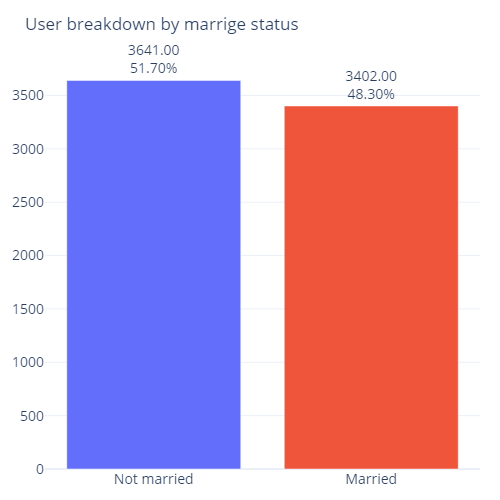

In [9]:
out = df.groupby('married', as_index=False).size().replace({0 : 'Not married', 1 : 'Married'})
ak.plot.bar(out, title='User breakdown by marrige status')

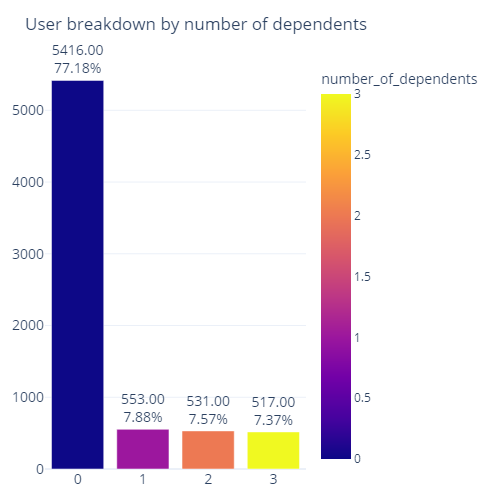

In [10]:
out = df.groupby('number_of_dependents', as_index=False).size()[:4]
ak.plot.bar(out, title='User breakdown by number of dependents')

These columns did not yield anything insights - everything looks normal.

### Insights about customer base

* Our customers are concentrated in larger cities of the state, specifically Los Angeles and San Diego
* They are, however, found throughout the whole state, which means that we, at the very least, have coverage in these places. It would be nice to see how the customer satisfaction and churn depends in these places compared to large cities
* The ages from 28 to 63 are slightly more prevalent in our customer base than state population, which, on one side, is to be expected given the services we offer, but, on the other side, we might be undertargeting the category of young adults, aged 21-28.

# How the clients are using our services

Below is the overall customer satisfaction score, that can then act as benchmark when we look at specific services:

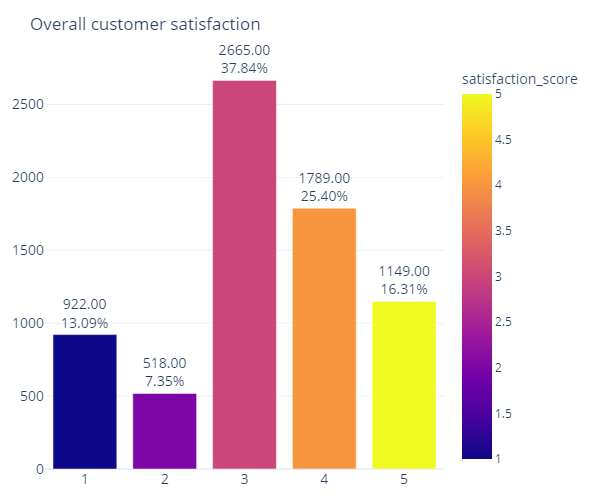

In [11]:
fig = ak.plot.bar(df.groupby('satisfaction_score', as_index=False).size(), title='Overall customer satisfaction')
fig.update_layout(width=600)

Below I compiled a list of services offered by the company.

Just looking at their popularity with customers is not really fun, let's look at their populatity combined with customer satisfaction to understand what services might drive customers off.

PS: each column on graph below is 100% total. This helps with comparing average satisfaction between groups with a big difference in service utilization.

Also, streaming TV and other customer activities that are not offered by Telco are still considered services here. This could help to pinpoint customer problems, potentially improving their satisfaction level.

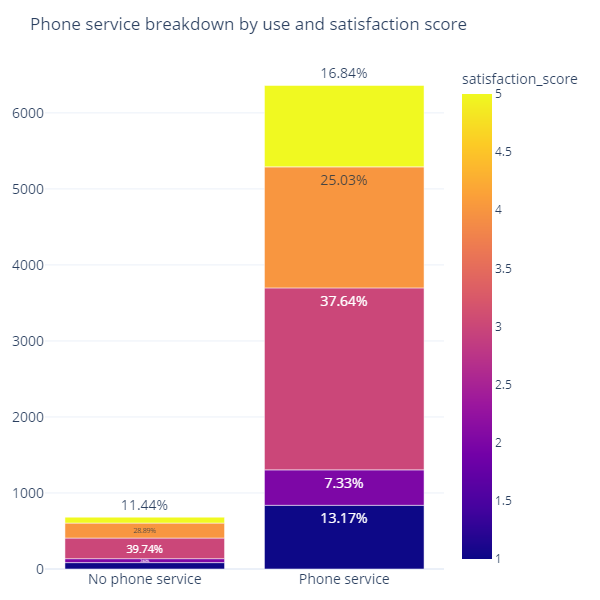

In [12]:
services_list = ['phone_service', 'multiple_lines', 'internet_service', 'internet_type',
                 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support',
                 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']

services_iter = iter(services_list)

def __service_plot():
    service = next(services_iter)
    srs = ak.humanize_srs(df[service])

    out = pd.concat([srs, df['satisfaction_score']], axis=1).groupby([srs.name, 'satisfaction_score'], as_index=False).size()

    fig = ak.plot.bar(out, title=f'{srs.name.capitalize()} breakdown by use and satisfaction score',
                        display_values=False)
    fig.update_layout(width=600, height=600)
    fig.show()
    return

__service_plot()

We see that most of our customers are using our phone service, and, perhaps, this is how we get new customers in the first place.

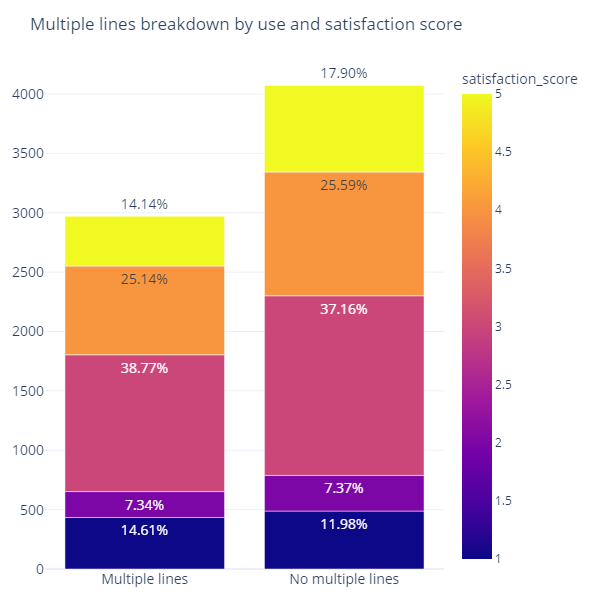

In [13]:
__service_plot()

Most of our customers do not use multiple lines. No sigficant change in satisfaction score noted.

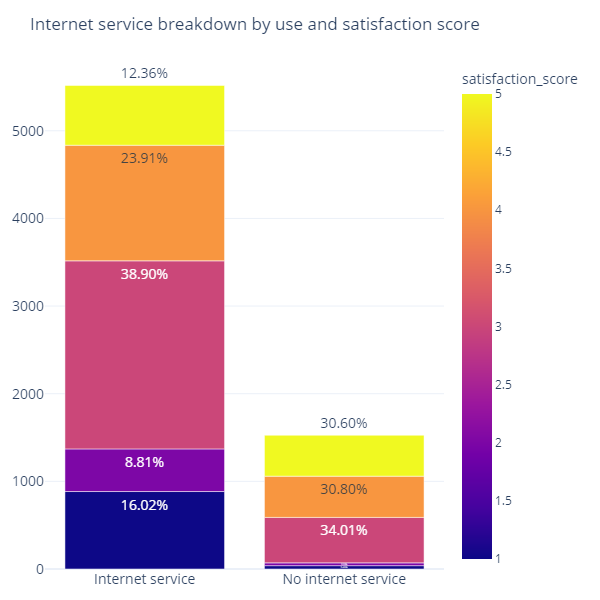

In [14]:
__service_plot()

The dissatisfaction level of our customers with internet service is a little too high. Maybe this means that we our internet service is bad for some specific geographical locations.

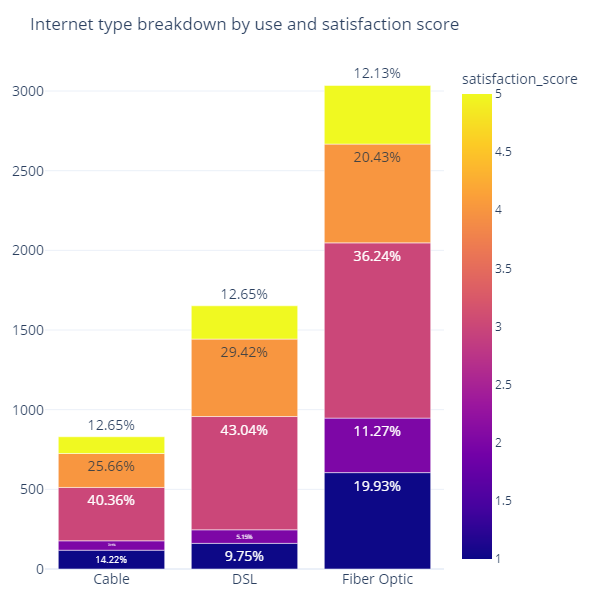

In [15]:
__service_plot()

We can see that our customers are okay with the DSL internet, but the fiber optic cable option would need some work.

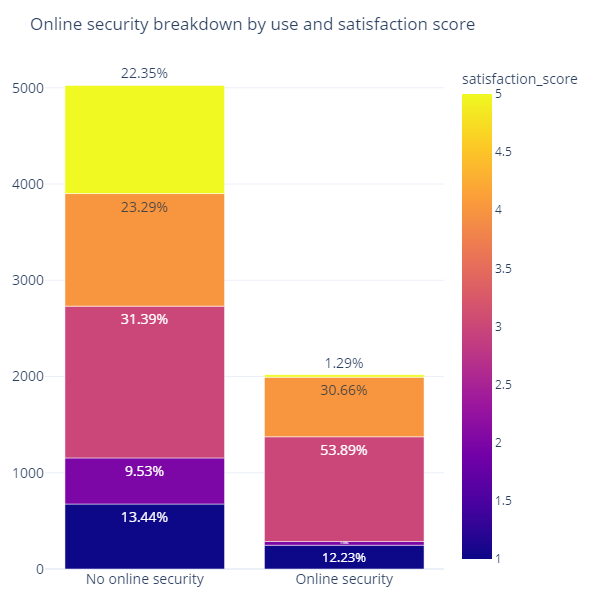

In [16]:
__service_plot()

Customers are overwhelmingly 'alright' with the online security. Perhaps, it would be nice to advertise this option to our customers more, since it raises their overall satisfaction level.

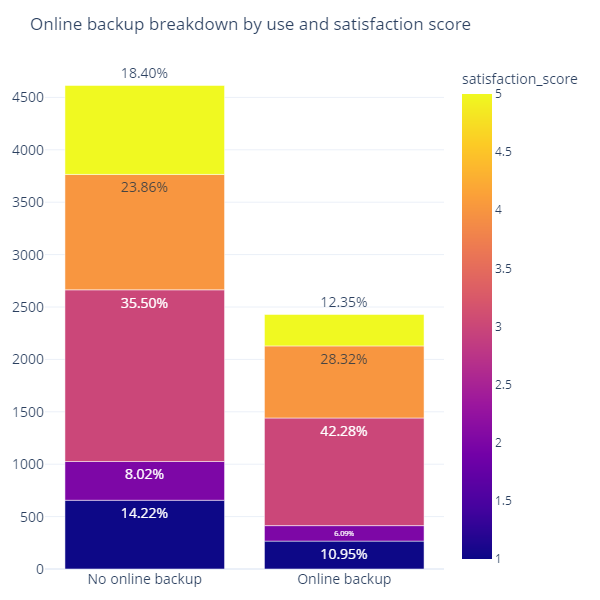

In [17]:
__service_plot()

Again, people with online backup are happier than those without it, so this service needs to be advertised more as well.

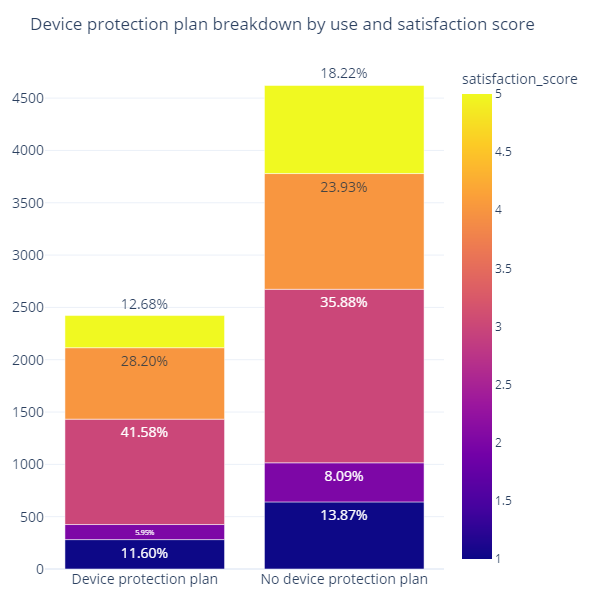

In [18]:
__service_plot()

Same here.

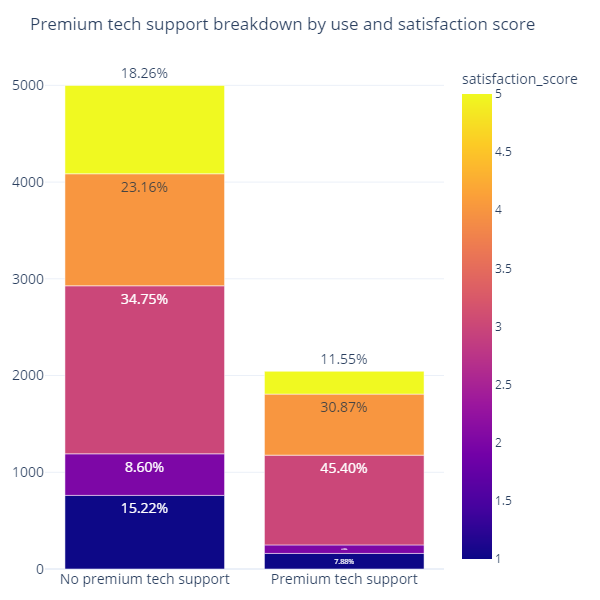

In [19]:
__service_plot()

Customers with premium tech support are a lot happier than the rest. Perhaps, even including a small free trial of tech support with various packages could drive more customer attention to this feature.

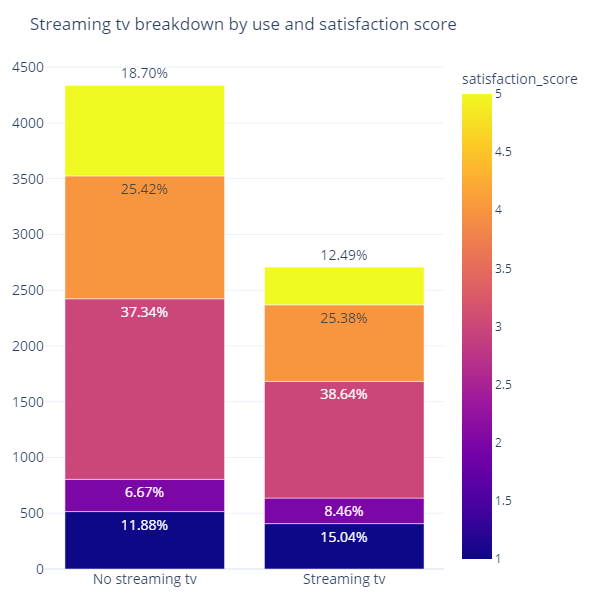

In [20]:
__service_plot()

Customers are a little dissatisfied with TV streaming, so this feature might need some work.

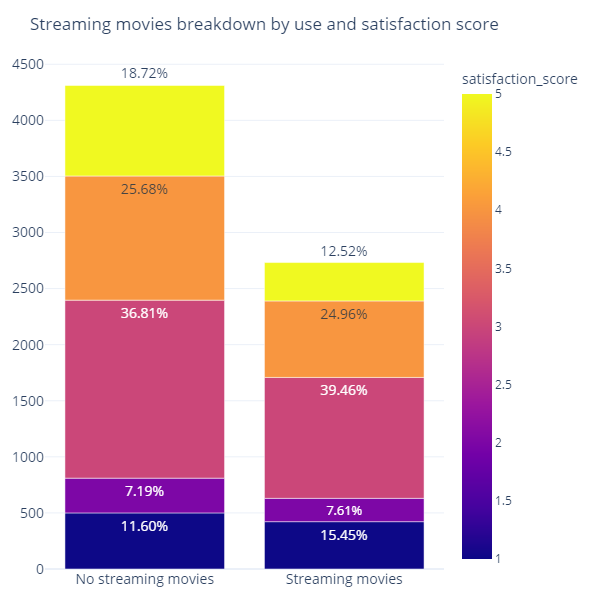

In [21]:
__service_plot()

Same exact picture here.

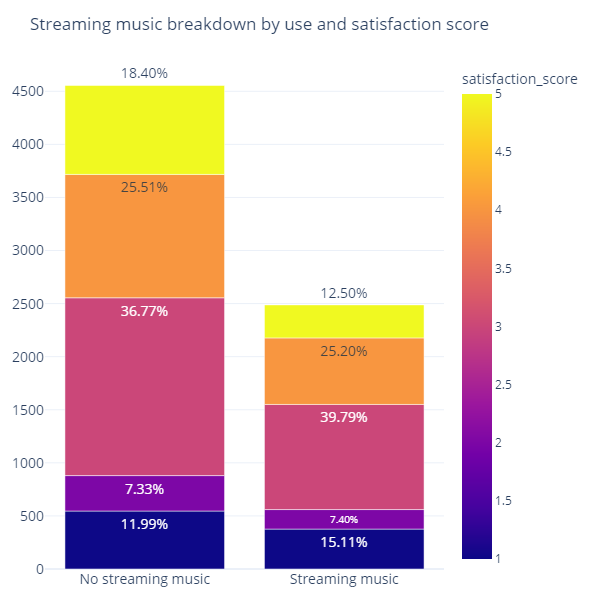

In [22]:
__service_plot()

All the streaming services have the exact same dynamic, which is something to be expected.

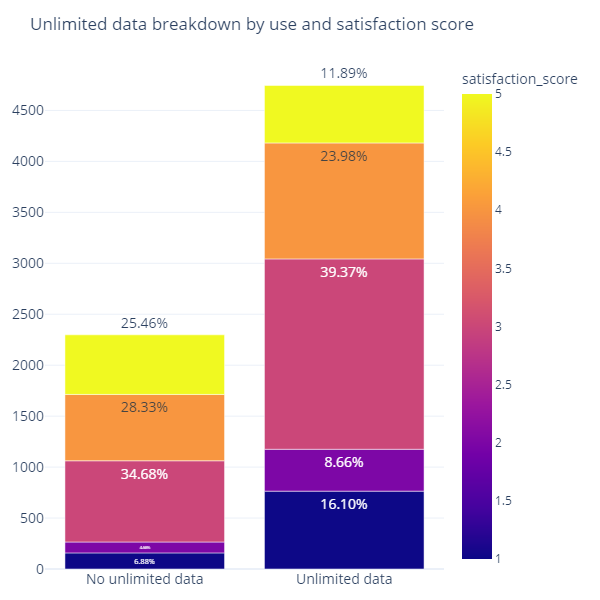

In [23]:
__service_plot()

Although most of our customers use unlimited data, they do not value the service that high. Eliminating all the problem with the unlimited data could potentially lower rate of satisfaction score 1 from 16 to 6%, which is massive.

### Insights about services (customer satisfaction)

We identified many services that could use some improvement, and some features that boost customer satisfaction, and thus should be advertised heavier to customers.

Services that need improvement, from most impactful to least:
* Unlimited data
* Fiber optic internet
* Streaming (TV, movies, music)
* Cable

Services that need to be pushed and advertised to customers heavier, from most impactful to least:
* Premium tech support
* Online backup
* Device protection plan
* Online security

Before we go on with the churn analysis, let's explore the tenure of the customers.

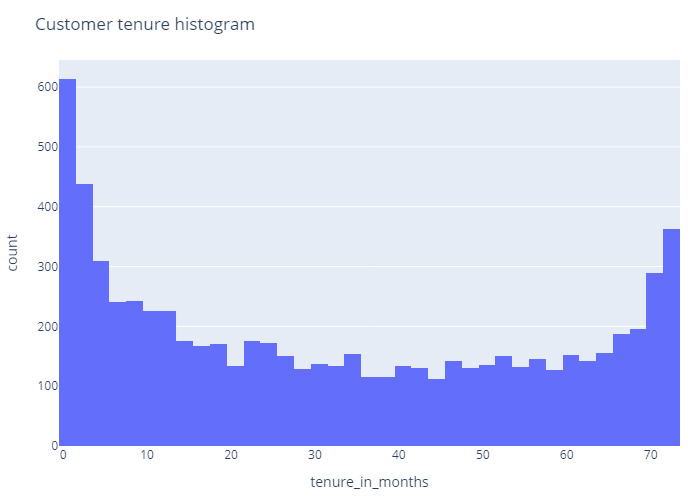

In [24]:
fig = px.histogram(df, x="tenure_in_months", title='Customer tenure histogram')
fig.update_layout(margin={'t':60,'b':20,'l':20,'r':20,'pad':0})

We could expect an exponential or log-normal distribution, but we see a completely different picture with a uniform distribution in tenure of most customers. Also, the number of customers with very high - 70+ months - tenure actually increases. Overall, the distribution is very unusual.

High bump at the end means that we have a cluster of very loyal customers worth investigating further.

In [25]:
df['high_tenure'] = (df['tenure_in_months'] >= 70).astype('int')
df[df['high_tenure'] == 1].head()

,gender,age,married,dependents,number_of_dependents,city,zip_code,latitude,longitude,population,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,churn,ibm_spss_churn_prob,cltv,churn_category,churn_reason,new_customer,age_bin,high_tenure
183,1,69,1,0,0,Soulsbyville,95372,37.99,-120.26,1519,1,1,70,NaN,1,17.45,1,1,Fiber Optic,20,0,1,1,0,1,1,0,1,Month-to-Month,1,Bank Withdrawal,102.95,"7,101.50",15.24,0,"1,221.50","8,307.76",1,1,91,5005,Competitor,Competitor had better devices,0,"(63.0, 71.0]",1
223,1,66,1,0,0,Lakewood,90713,33.85,-118.11,27563,0,0,72,NaN,1,6.03,1,1,Fiber Optic,2,0,1,1,0,1,1,0,1,Two Year,1,Bank Withdrawal,104.15,"7,689.95",0.00,0,434.16,"8,124.11",3,1,74,5925,Price,Extra data charges,0,"(63.0, 71.0]",1
294,0,78,1,0,0,Merced,95348,37.40,-120.51,23100,0,0,72,NaN,1,25.77,1,1,DSL,6,1,1,1,1,1,1,0,1,Two Year,0,Credit Card,92.45,"6,440.25",0.00,0,"1,855.44","8,295.69",1,1,78,5697,Competitor,Competitor made better offer,0,"(71.0, 80.0]",1
378,1,79,1,0,0,Big Pine,93513,37.25,-118.06,1826,1,1,71,NaN,1,44.66,1,1,Fiber Optic,8,1,1,0,0,1,1,1,1,Month-to-Month,1,Credit Card,105.10,"7,548.10",0.00,0,"3,170.86","10,718.96",1,1,66,5725,Attitude,Attitude of support person,0,"(71.0, 80.0]",1
388,1,79,0,0,0,Portola Valley,94028,37.37,-122.22,6601,0,0,70,NaN,0,0.00,0,1,DSL,20,0,0,0,0,1,1,0,1,One Year,1,Bank Withdrawal,45.25,"3,264.45",0.00,0,0.00,"3,264.45",2,1,90,5824,Attitude,Attitude of service provider,0,"(71.0, 80.0]",1


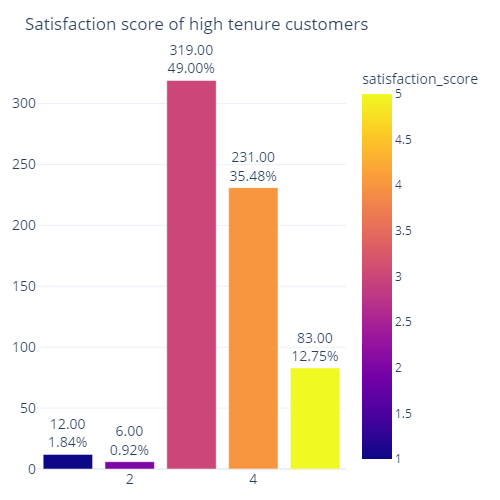

In [26]:
ak.plot.bar(df[df['high_tenure'] == 1].groupby('satisfaction_score', as_index=False).size(), title='Satisfaction score of high tenure customers')

The cluster of customers with high tenure has high satisfaction scores, which is to be expected.

Let's see if there are any services that this cluster of clients prefers (uses more than the rest).

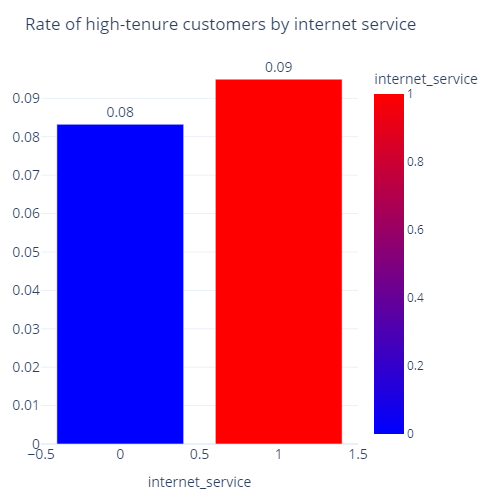

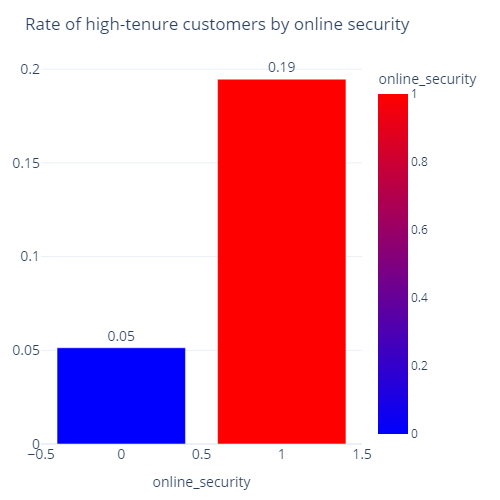

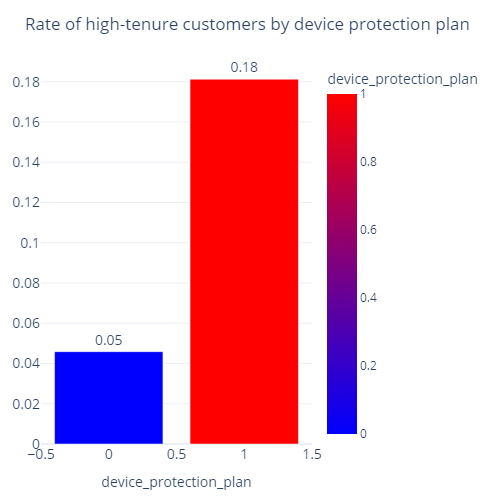

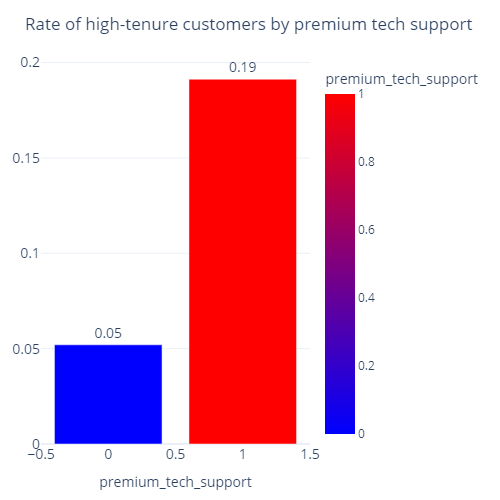

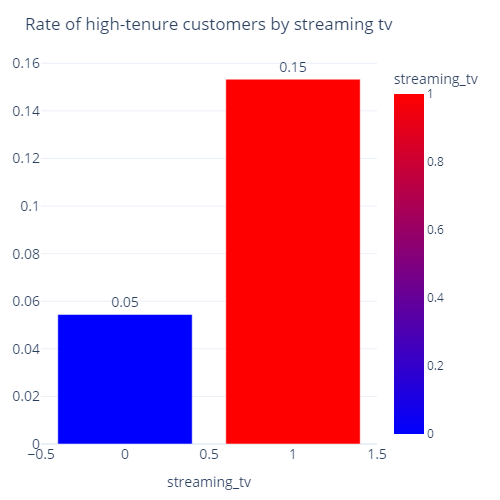

In [27]:
services_list_small = ['internet_service', 'online_security', 'device_protection_plan', 'premium_tech_support', 'streaming_tv']

for service in services_list_small:
    fig = ak.plot.bar(df.groupby(service, as_index=False)['high_tenure'].mean(),
        color_continuous_scale=px.colors.sequential.Bluered,
        title=f'Rate of high-tenure customers by {service.replace("_", " ")}',
        display_pct=False)
    fig.update_layout(xaxis=dict(title=service))
    fig.show()

So, our customers with the most tenure are using such services at much higher rates than the other ones:
* Online security
* Device protection plan
* Premium tech support
* Streaming services

From the customer viewpoint it might mean that it is harder to switch the companies when it comes to these services. It makes sense in the case of online security, device protection plan and streaming services, but not premium tech support.

From our viewpoint it means that giving a discount for long-term subscription to these services might score us more long-term customers.

# Churn analysis

Let's look at the mean churn by service.

In [28]:
service_churn_df = pd.DataFrame()

for service in ['phone_service', 'multiple_lines',
                 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support',
                 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']:
    out = pd.DataFrame({'col' : service, 'churn' : [df.loc[df[service] == 1, 'churn'].mean()]})
    service_churn_df = pd.concat([service_churn_df, out])

out = df.groupby('internet_type', as_index=False)['churn'].mean()
out.columns = ['col', 'churn']
service_churn_df = pd.concat([service_churn_df, out])

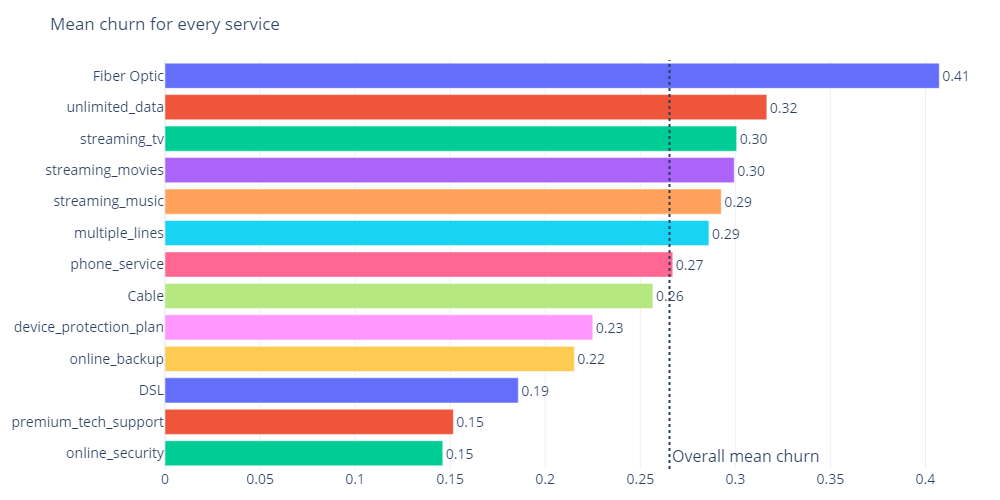

In [29]:
fig = ak.plot.bar(service_churn_df.sort_values(by='churn', ascending=False), h=True, display_pct=False, title='Mean churn for every service')
fig.update_layout(width=1000)
fig.add_vline(df['churn'].mean(), line_dash="dot", annotation_text="Overall mean churn", annotation_position="bottom right", annotation=dict(font_size=16))

The insights we can gain from this graph largely repeat what we have already covered in "Insights about services (customer satisfaction)" chapter.

Let's look at top churn reasons.

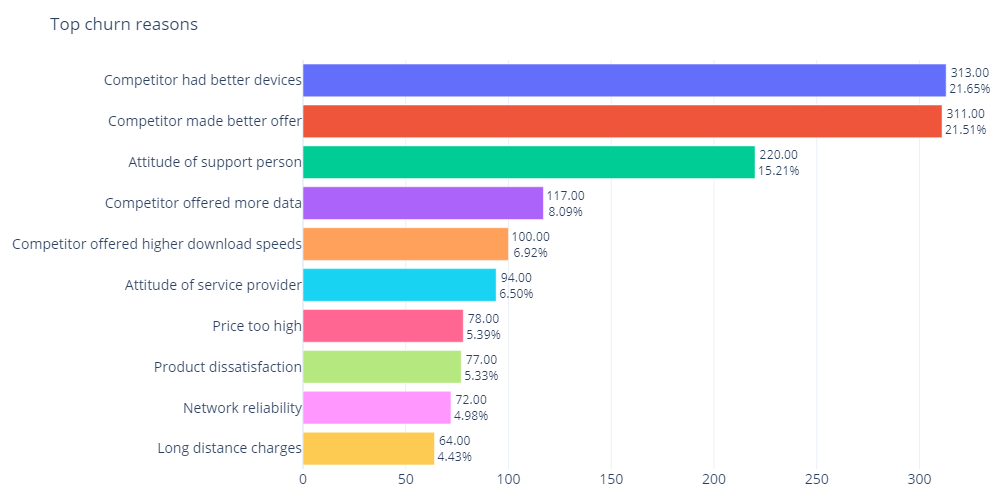

In [30]:
out = df.groupby('churn_reason', as_index=False).size().sort_values(by='size', ascending=False)[:11]
out = out[out['churn_reason'] != "Don't know"]
fig = ak.plot.bar(out, h=True, title='Top churn reasons')
fig.update_layout(width=1000)

So, we see 3 major reasons:
* Competitor had better devices
* Competitor made better offer
* Attitude of support person

The problem is that there are too many reasons, and some of them are very close in meaning. Let's explore churn_category column which should aggregate these.

In [31]:
df.groupby(['churn_category', 'churn_reason']).size()

churn_category   churn_reason                             
Attitude         Attitude of service provider                  94
                 Attitude of support person                   220
Competitor       Competitor had better devices                313
                 Competitor made better offer                 311
                 Competitor offered higher download speeds    100
                 Competitor offered more data                 117
Dissatisfaction  Lack of self-service on Website               29
                 Limited range of services                     37
                 Network reliability                           72
                 Poor expertise of online support              13
                 Poor expertise of phone support               12
                 Product dissatisfaction                       77
                 Service dissatisfaction                       63
Other            Deceased                                       6
                 

As you can see, the churn_category column is not really good at times:
* Same reason is put into separate categories: 'Poor expertise of online support' into 'Other' and 'Dissatisfaction'
* The reasons in the same category are very thematically different: 'Dissatisfaction' has 'Network reliability', which relates more to the technological side of business, and 'Poor expertise...', which relates to personnel issues.

So, I came up with a new classification that can help us look at a bigger picture regarding services:

In [32]:
own_churn_category = {'Personnel' : ['Attitude of service provider', 'Attitude of support person',
                                     'Poor expertise of online support', 'Poor expertise of phone support'],
                      'Technology' : ['Competitor had better devices', 'Lack of self-service on Website',
                                      'Limited range of services', 'Network reliability'],
                      'Prices' : ['Extra data charges', 'Lack of affordable download/upload speed',
                                  'Long distance charges', 'Price too high'],
                      'Competitor offer' : ['Competitor made better offer', 'Competitor offered higher download speeds',
                                            'Competitor offered more data'],
                      'General dissatisfaction' : ['Product dissatisfaction', 'Service dissatisfaction']
                      }

In [33]:
__list = []

for key, value in own_churn_category.items():
    __list.extend(value)
 
[reason for reason in list(df['churn_reason'].unique()) if reason not in __list]

["Don't know", 'Moved', 'Deceased', nan]

Notice that we don't include reasons like 'Don't know' and such. I believe they would not help us to pinpoint our weak points, so they were excluded.

Let's breakdown service churn by newly created churn categories. 

In [34]:
own_churn_category_transfrom = dict()
for key, values in own_churn_category.items():
    for value in values:
        own_churn_category_transfrom[value] = key

df['churn_category2'] = df['churn_reason'].replace(own_churn_category_transfrom)
df.loc[~df['churn_category2'].isin(own_churn_category.keys()), 'churn_category2'] = np.nan

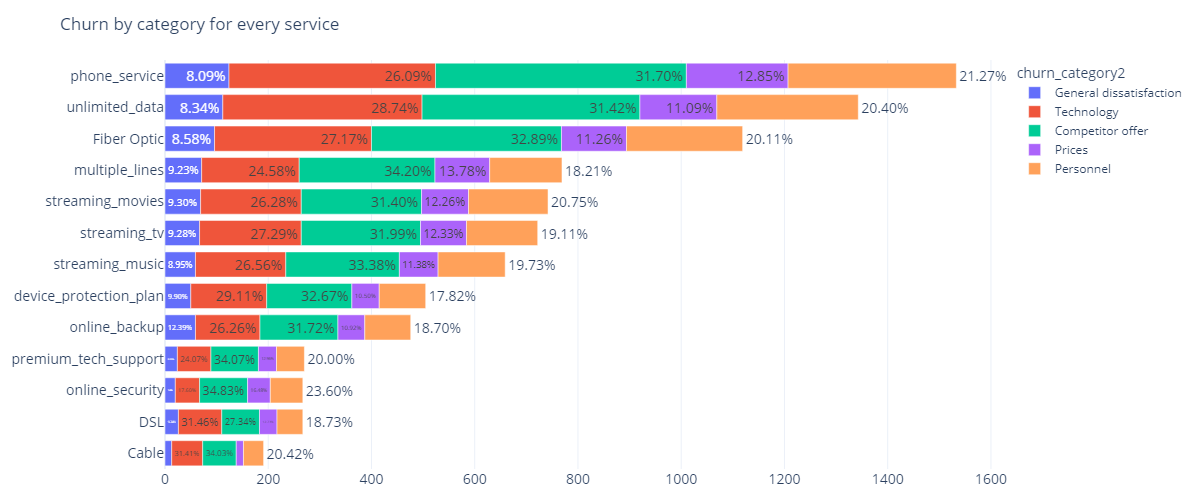

In [35]:
service_cat2_churn_df = pd.DataFrame()

for service in ['phone_service', 'multiple_lines',
                 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support',
                 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']:
    out = df[df[service] == 1].groupby('churn_category2', as_index=False).size()
    out['col'] = service
    service_cat2_churn_df = pd.concat([service_cat2_churn_df, out])

out = df.groupby(['churn_category2', 'internet_type'], as_index=False).size()
out.columns = ['churn_category2', 'col', 'size']
service_cat2_churn_df = pd.concat([service_cat2_churn_df, out])
service_cat2_churn_df = service_cat2_churn_df[['col', 'churn_category2', 'size']]

# sorting by the sum of the group
# dict below just sorts groups from largest to smallest and assigns them indexes
sorting_dict = {cat: i for i, cat in enumerate(service_cat2_churn_df.groupby('col')['size'].sum().sort_values().index)}

service_cat2_churn_df['sorting_index'] = service_cat2_churn_df['col'].map(sorting_dict)

service_cat2_churn_df = service_cat2_churn_df.sort_values(by='sorting_index')
service_cat2_churn_df = service_cat2_churn_df.drop('sorting_index', axis=1)

# finally, plotting
fig = ak.plot.bar(service_cat2_churn_df, h=True, title='Churn by category for every service', display_values=False)
fig.update_layout(width=1200, showlegend=True)
fig.show()

Insights for this graph are presented below.

### Insights on customer churn

The services with the highest churn rates are:
* Fibre optic cable internet
* Unlimited data

These results also coincide with insights about customer satisfaction, showing that they have low ratings.

The biggest reasons for churn are:
* Non-competitive proposals or devices
* Attitude of the support personnel

These specific problems have been identified with the following services:
* Online backup - too much general dissatisfaction with the product
* Unlimited data, Device protection plan - bad or unreliable devices, unstable network etc
* Multiple phone lines - bad, non-competitive offers
* Phone service and movie streaming - poor attitude or expertise of support or service provider

As for recommendations, I propose the following measures:
* Additional training of support personnel or service providers to ensure proper customer satisfaction
* Upgrading devices to match competitors' levels
* Offer more data and download speeds in offers
* Increasing prices on offers, as dissatisfaction level tied to service prices is relatively low

# Feature selection and engineering

In [36]:
df.head()

,gender,age,married,dependents,number_of_dependents,city,zip_code,latitude,longitude,population,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,churn,ibm_spss_churn_prob,cltv,churn_category,churn_reason,new_customer,age_bin,high_tenure,churn_category2
0,1,78,0,0,0,Los Angeles,90022,34.02,-118.16,68701,0,0,1,NaN,0,0.00,0,1,DSL,8,0,0,1,0,0,1,0,0,Month-to-Month,1,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,3,1,91,5433,Competitor,Competitor offered more data,0,"(71.0, 80.0]",0,Competitor offer
1,0,74,1,1,1,Los Angeles,90063,34.04,-118.19,55668,1,1,8,Offer E,1,48.85,1,1,Fiber Optic,17,0,1,0,0,0,0,0,1,Month-to-Month,1,Credit Card,80.65,633.30,0.00,0,390.80,"1,024.10",3,1,69,5302,Competitor,Competitor made better offer,0,"(71.0, 80.0]",0,Competitor offer
2,1,71,0,1,3,Los Angeles,90065,34.11,-118.23,47534,0,0,18,Offer D,1,11.33,1,1,Fiber Optic,52,0,0,0,0,1,1,1,1,Month-to-Month,1,Bank Withdrawal,95.45,"1,752.55",45.61,0,203.94,"1,910.88",2,1,81,3179,Competitor,Competitor made better offer,0,"(63.0, 71.0]",0,Competitor offer
3,0,78,1,1,1,Inglewood,90303,33.94,-118.33,27778,1,1,25,Offer C,1,19.76,0,1,Fiber Optic,12,0,1,1,0,1,1,0,1,Month-to-Month,1,Bank Withdrawal,98.50,"2,514.50",13.43,0,494.00,"2,995.07",2,1,88,5337,Dissatisfaction,Limited range of services,0,"(71.0, 80.0]",0,Technology
4,0,80,1,1,1,Whittier,90602,33.97,-118.02,26265,1,1,37,Offer C,1,6.33,1,1,Fiber Optic,14,0,0,0,0,0,0,0,1,Month-to-Month,1,Bank Withdrawal,76.50,"2,868.15",0.00,0,234.21,"3,102.36",2,1,67,2793,Price,Extra data charges,0,"(71.0, 80.0]",0,Prices


First, let's delete the columns we created during EDA, and additional columns we shouldn't observe during inference.

In [37]:
df = df.drop(['age_bin', 'high_tenure', 'churn_category2', 'ibm_spss_churn_prob', 'churn_category', 'churn_reason', 'new_customer'], axis=1)

Information about geological location in contained latitude and longitude, we do not need to include zip, city or city population.

Columns dependents and referred_a_friend are not needed, because we have number_of_dependents and number_of_referrals.

In [38]:
df = df.drop(['dependents', 'city', 'zip_code', 'population', 'referred_a_friend'], axis=1)

We do not need both internet_service and internet_type, so we drop the former.

In [39]:
df = df.drop('internet_service', axis=1)

We have two columns for distance charges: avg_monthly_long_distance_charges and total_long_distance_charges (quarter), so we drop the former.

Same goes for monthly_charge and total_charges.

In [40]:
df = df.drop(['avg_monthly_long_distance_charges', 'monthly_charge'], axis=1)

The columns total_charges and total_revenue should represent the same thing, and, taking into account their almost perfect correlation - 0.97 - we drop the latter.

In [41]:
df = df.drop('total_revenue', axis=1)

I believe monetary columns like refunds or extra charges do not mean much by themselves, so we normalize them by total_charges column.

In [42]:
for col in ['total_refunds',
 'total_extra_data_charges',
 'total_long_distance_charges']:
    df[col] = df[col] / df['total_charges']

The customers use varying number of services, so it would make sense to make a new column that normalizes total charges by number of services that incur a fee.

In [43]:
df['n_services'] = df[['phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection_plan',
 'premium_tech_support',
 'unlimited_data']].sum(axis=1) + 1 - df['internet_type'].isna() # 1 - df['internet_type'].isna() just means that the client is using the internet

df['corr_total_charges'] = df['total_charges'] / df['n_services']

Next, we will encode categorical columns: offer, internet_type, contract, payment_method.

Note that offer and internet_type contain NaN, so, for these columns, we need to regard that. If you pass 'dummy_na = True' for columns that don't contain NaNs, pandas will still make a corresponding NaN column, which is an understandable, but still unnecessary behaviour.

In [44]:
df = pd.get_dummies(df, columns=['contract', 'payment_method'], drop_first=True, dtype='int')
df = pd.get_dummies(df, columns=['offer', 'internet_type'], dummy_na = True, drop_first=True, dtype='int')
df.head()

,gender,age,married,number_of_dependents,latitude,longitude,number_of_referrals,tenure_in_months,phone_service,multiple_lines,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,paperless_billing,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,satisfaction_score,churn,cltv,n_services,corr_total_charges,contract_One Year,contract_Two Year,payment_method_Credit Card,payment_method_Mailed Check,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E,offer_nan,internet_type_DSL,internet_type_Fiber Optic,internet_type_nan
0,1,78,0,0,34.02,-118.16,0,1,0,0,8,0,0,1,0,0,1,0,0,1,39.65,0.00,0.50,0.00,3,1,5433,2,19.82,0,0,0,0,0,0,0,0,1,1,0,0
1,0,74,1,1,34.04,-118.19,1,8,1,1,17,0,1,0,0,0,0,0,1,1,633.30,0.00,0.00,0.62,3,1,5302,5,126.66,0,0,1,0,0,0,0,1,0,0,1,0
2,1,71,0,3,34.11,-118.23,0,18,1,1,52,0,0,0,0,1,1,1,1,1,"1,752.55",0.03,0.00,0.12,2,1,3179,4,438.14,0,0,0,0,0,0,1,0,0,0,1,0
3,0,78,1,1,33.94,-118.33,1,25,1,0,12,0,1,1,0,1,1,0,1,1,"2,514.50",0.01,0.00,0.20,2,1,5337,5,502.90,0,0,0,0,0,1,0,0,0,0,1,0
4,0,80,1,1,33.97,-118.02,1,37,1,1,14,0,0,0,0,0,0,0,1,1,"2,868.15",0.00,0.00,0.08,2,1,2793,4,717.04,0,0,0,0,0,1,0,0,0,0,1,0


One hot encoding broke our column naming convention, so we fix that.

In [45]:
df.columns = [col.replace(' ', '_').lower() for col in df.columns]

Next, we look at the correlation matrix.

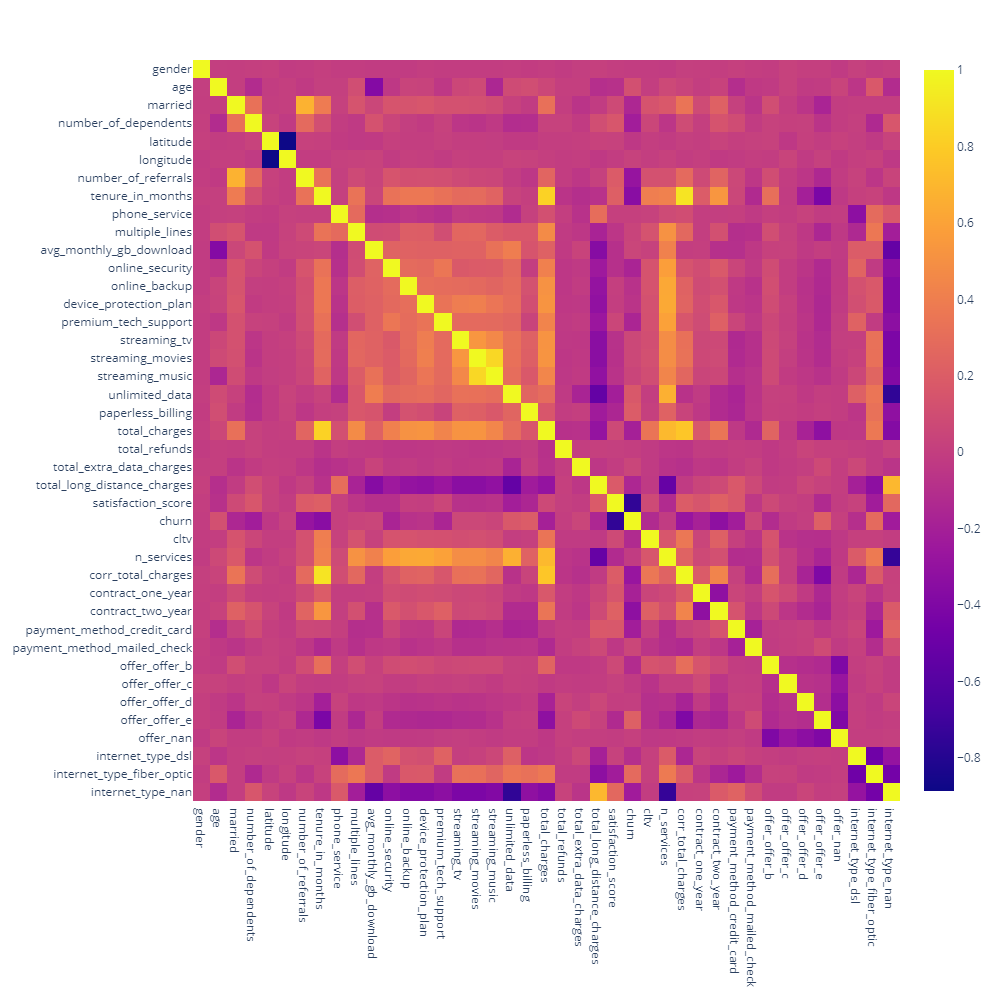

In [46]:
fig = px.imshow(df.corr(), aspect='auto')
fig.update_layout(width=1000, height=1000)
fig.show()

We can see some strong correlation between variables, but it is very impractical to try to extract insights from this graph.

Below are the pairs of features that have more than 0.6 absolute correlation.

In [47]:
corr = ak.corr(df)
corr

,var1,var2,corr,abs_corr
1155,corr_total_charges,tenure_in_months,0.91,0.91
209,longitude,latitude,-0.89,0.89
713,streaming_music,streaming_movies,0.85,0.85
307,tenure_in_months,total_charges,0.83,0.83
848,total_charges,corr_total_charges,0.77,0.77
778,unlimited_data,internet_type_nan,-0.76,0.76
1049,churn,satisfaction_score,-0.75,0.75
1147,n_services,internet_type_nan,-0.74,0.74
1127,n_services,total_charges,0.71,0.71
983,total_long_distance_charges,internet_type_nan,0.70,0.70


We can present the results in a different way - by specific columns occurences

In [53]:
corr.top()

,var,mean_corr,n
0,n_services,0.67,5
0,total_charges,0.77,3
0,internet_type_nan,0.73,3
0,corr_total_charges,0.84,2
0,tenure_in_months,0.87,2
0,unlimited_data,0.71,2
0,streaming_movies,0.85,1
0,device_protection_plan,0.63,1
0,married,0.67,1
0,satisfaction_score,0.75,1


We see that n_services has very high number of high correlation relationships (column n) with other columns.

Let's visualize the table as graph to better understand what to plot.

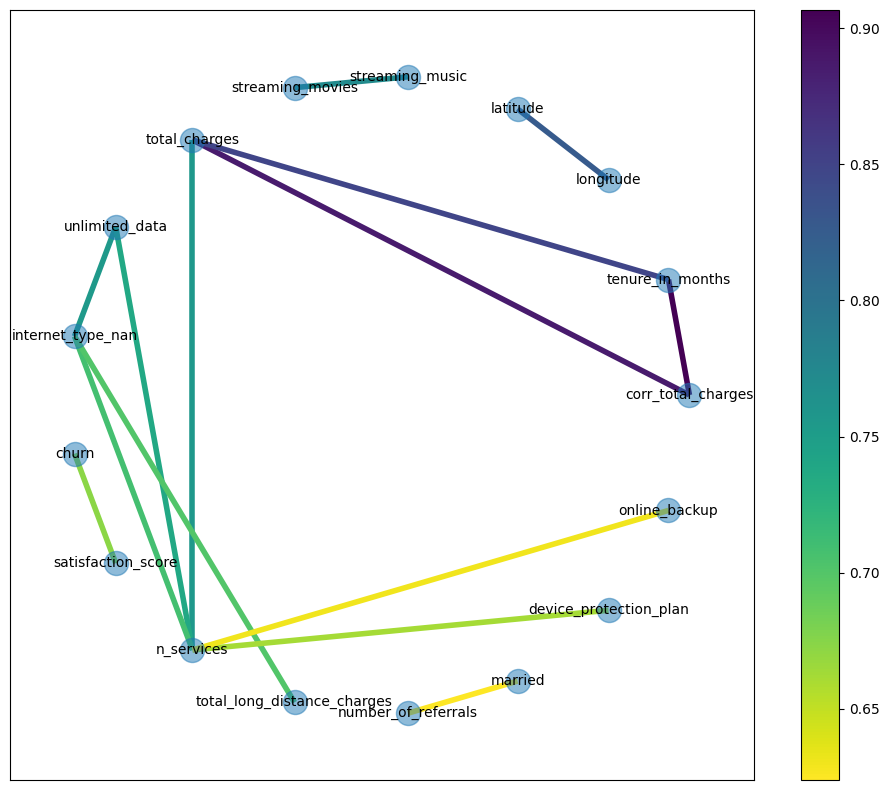

In [49]:
corr.graph()

So, we should drop n_services and leave only 1 variable from total_charges, tenure_in_months and corr_total_charges. Considering that total_charges and tenure_in_months are not normalized by anything, it would make more sense to leave corr_total_charges.

In [50]:
df = df.drop(['n_services', 'total_charges', 'tenure_in_months'], axis=1)

Steaming music or movies column has too correlation, so we fuse these variables.

In [58]:
df['streaming_music_or_movies'] = df['streaming_music'] | df['streaming_movies']
df = df.drop(['streaming_music', 'streaming_movies'], axis=1)

In [63]:
df.head(-5)

,gender,age,married,number_of_dependents,latitude,longitude,number_of_referrals,phone_service,multiple_lines,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,unlimited_data,paperless_billing,total_refunds,total_extra_data_charges,total_long_distance_charges,satisfaction_score,churn,cltv,corr_total_charges,contract_one_year,contract_two_year,payment_method_credit_card,payment_method_mailed_check,offer_offer_b,offer_offer_c,offer_offer_d,offer_offer_e,offer_nan,internet_type_dsl,internet_type_fiber_optic,internet_type_nan,streaming_music_or_movies
0,1,78,0,0,34.02,-118.16,0,0,0,8,0,0,1,0,0,0,1,0.00,0.50,0.00,3,1,5433,19.82,0,0,0,0,0,0,0,0,1,1,0,0,1
1,0,74,1,1,34.04,-118.19,1,1,1,17,0,1,0,0,0,1,1,0.00,0.00,0.62,3,1,5302,126.66,0,0,1,0,0,0,0,1,0,0,1,0,0
2,1,71,0,3,34.11,-118.23,0,1,1,52,0,0,0,0,1,1,1,0.03,0.00,0.12,2,1,3179,438.14,0,0,0,0,0,0,1,0,0,0,1,0,1
3,0,78,1,1,33.94,-118.33,1,1,0,12,0,1,1,0,1,1,1,0.01,0.00,0.20,2,1,5337,502.90,0,0,0,0,0,1,0,0,0,0,1,0,1
4,0,80,1,1,33.97,-118.02,1,1,1,14,0,0,0,0,0,1,1,0.00,0.00,0.08,2,1,2793,717.04,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7033,0,23,1,0,33.28,-115.96,2,1,0,53,0,1,0,1,1,1,0,0.00,0.00,0.14,5,0,5553,865.25,0,1,0,0,0,0,0,0,1,1,0,0,0
7034,0,57,0,0,33.14,-116.97,0,1,0,0,0,0,0,0,0,0,1,0.00,0.00,0.35,3,0,5191,39.25,0,0,0,1,0,0,0,1,0,0,0,1,0
7035,1,63,0,0,33.04,-115.61,0,1,0,2,0,0,0,0,0,1,1,0.01,0.00,0.51,3,0,4591,875.08,0,0,1,0,0,0,0,0,1,0,1,0,0
7036,1,57,0,0,32.85,-114.85,0,1,0,13,0,0,0,0,1,1,1,0.02,0.00,0.38,3,0,2464,498.37,0,0,0,0,0,0,0,0,1,0,1,0,0


In [64]:
df.to_csv(os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'data', 'telco_processed_2.csv'))), index=False)

# Insight summary

**Customer portrait**

* Our customers are concentrated in larger cities of the state, specifically Los Angeles and San Diego
* They are, however, found throughout the whole state, which means that we, at the very least, have coverage in these places. It would be nice to see how the customer satisfaction and churn depends in these places compared to large cities
* The ages from 28 to 63 are slightly more prevalent in our customer base than state population, which, on one side, is to be expected given the services we offer, but, on the other side, we might be undertargeting the category of young adults, aged 21-28.

**Services**

Services that need improvement, from most impactful to least:
* Unlimited data
* Fiber optic internet
* Streaming TV, movies or music experiences
* Cable internet

Services that need to be pushed and advertised to customers heavier, from most impactful to least:
* Premium tech support
* Online backup
* Device protection plan
* Online security

The biggest reasons for churn are:
* Non-competitive proposals or devices
* Attitude of the support personnel

Specific problems with some of the services:
* Online backup - too much general dissatisfaction with the product
* Unlimited data, Device protection plan - bad or unreliable devices, unstable network etc
* Multiple phone lines - bad, non-competitive offers
* Phone service and movie streaming - poor attitude or expertise of support or service provider

My recommendations regarding services:
* Additional training of support personnel or service providers to ensure proper customer satisfaction
* Upgrading devices to match competitors' levels
* Offer more data and download speeds in offers
* Increasing prices on offers (dissatisfaction level tied to service prices is relatively low)